<a href="https://colab.research.google.com/github/romaniuk-o/Python_Data_Science_HW9/blob/main/tensorflow_mnist_hw_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [4]:
from tensorflow import keras
from keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(num_features, n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Выходной слой
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    x1 = self.layer_1(x)
    x2 = self.layer_2(x1)
    
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    x3 = self.out_layer(x2)
    return tf.nn.softmax(x3)

In [6]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [7]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

   

In [8]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)
        
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")
        

Step: 0, Loss: 606.7489624023438, Accuracy: 0.11328125
Step: 100, Loss: 574.962646484375, Accuracy: 0.125
Step: 200, Loss: 531.3390502929688, Accuracy: 0.31640625
Step: 300, Loss: 520.003662109375, Accuracy: 0.41796875
Step: 400, Loss: 495.3519287109375, Accuracy: 0.484375
Step: 500, Loss: 491.6146240234375, Accuracy: 0.484375
Step: 600, Loss: 481.93499755859375, Accuracy: 0.55078125
Step: 700, Loss: 468.0910339355469, Accuracy: 0.6015625
Step: 800, Loss: 467.92962646484375, Accuracy: 0.59375
Step: 900, Loss: 459.1038818359375, Accuracy: 0.64453125
Step: 1000, Loss: 459.52191162109375, Accuracy: 0.671875
Step: 1100, Loss: 465.4771728515625, Accuracy: 0.62890625
Step: 1200, Loss: 455.4234619140625, Accuracy: 0.66796875
Step: 1300, Loss: 453.7061462402344, Accuracy: 0.6640625
Step: 1400, Loss: 455.58782958984375, Accuracy: 0.671875
Step: 1500, Loss: 448.8953552246094, Accuracy: 0.72265625
Step: 1600, Loss: 449.09197998046875, Accuracy: 0.6796875
Step: 1700, Loss: 443.80426025390625, Accu

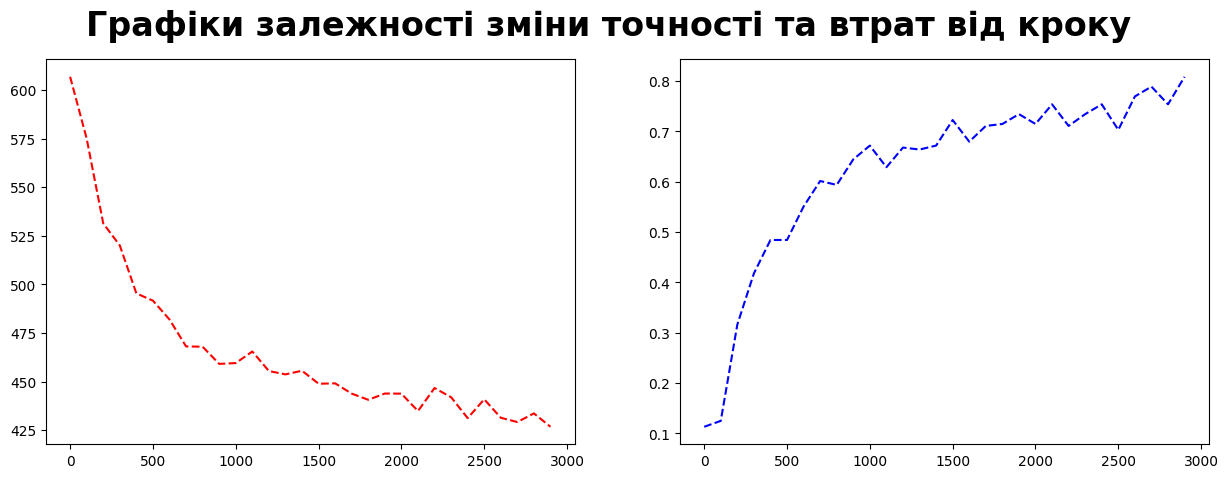

In [19]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

epochs = [i for i in range(0, training_steps, display_step)]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Графіки залежності зміни точності та втрат від кроку', fontsize=24, fontweight='bold')

axes[0].plot(epochs, loss_history, 'r--')
axes[1].plot(epochs, accuracy_history, 'b--')
plt.show()


In [14]:
# Вычислите точность обученной нейросети

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.750249981880188


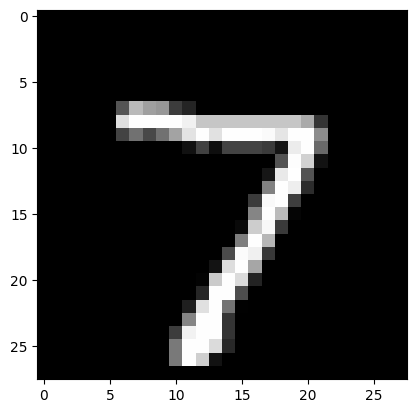

NN result:7


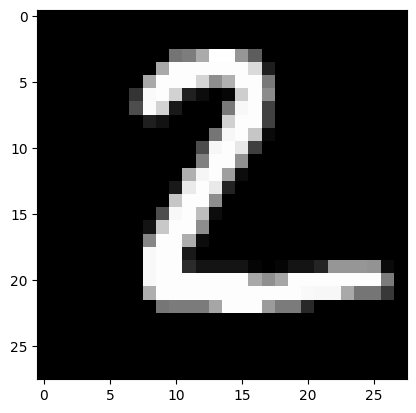

NN result:0


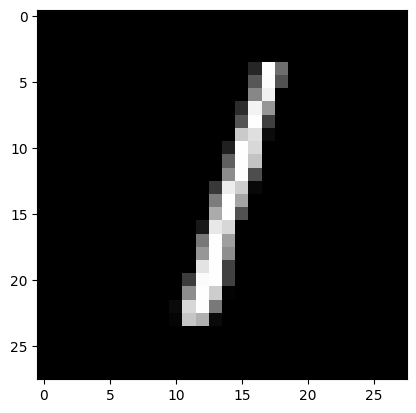

NN result:1


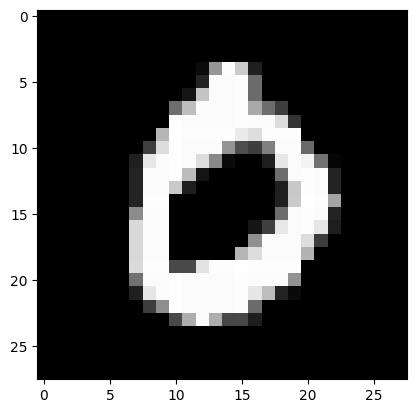

NN result:0


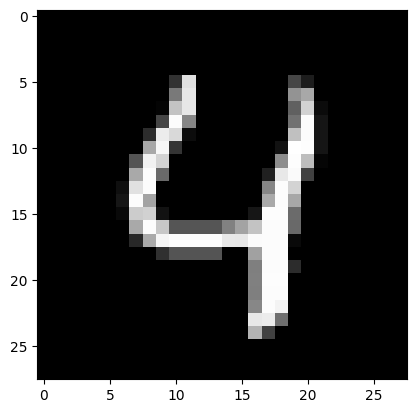

NN result:4


In [16]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

import matplotlib.pyplot as plt
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i],[28,28]),cmap='gray')
    plt.show()
    print('NN result:%i'%np.argmax(predictions.numpy()[i]))